In [1]:
import numpy as np
import pandas as pd
import scanpy as sc 
import scirpy as ir 
import muon as mu

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [3]:
mdata = mu.read("/Users/jerryaaaaaa/tcr_model.h5mu")

/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Drop cells with NA clonal_dynamic_label

In [4]:
valid_cells = mdata["gex"].obs[~mdata["gex"].obs["clonal_dynamic_label"].isna()].index
mdata_filtered = mdata[valid_cells].copy()

Assign proxy label(criteria: reactivity_score > 0.5 and expansion_fold > 1)

In [7]:
def assign_proxy_label(row, score_thresh=0.5, expansion_thresh=1):
    if row["reactivity_score"] > score_thresh and row["expansion_fold"] > expansion_thresh:
        return "Reactive"
    else:
        return "Nonreactive"
mdata_filtered["gex"].obs["proxy_label"] = mdata_filtered["gex"].obs.apply(assign_proxy_label, axis=1)

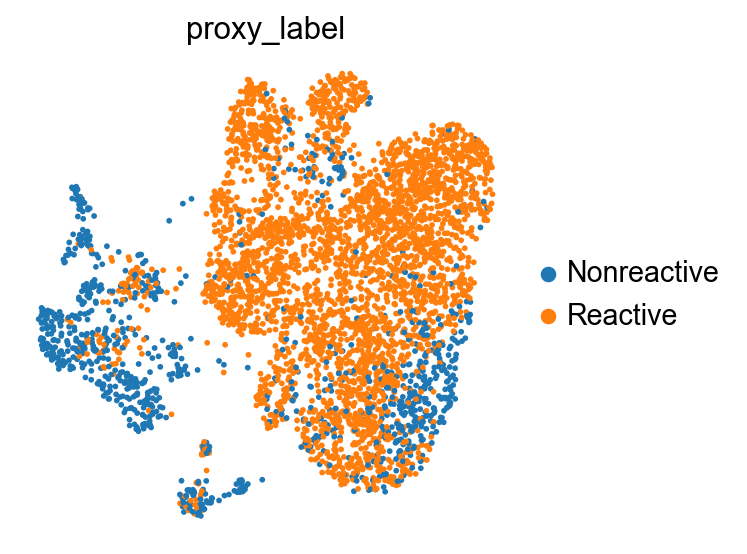

In [8]:
sc.pl.umap(mdata_filtered["gex"], color="proxy_label", frameon=False)

In [9]:
from sklearn.model_selection import train_test_split

Extract cells_id for train/test split

Stratify = labels(targets) ensures the proportion of each class is preserved in both train and test sets

In [10]:
cell_ids = mdata_filtered.obs_names
labels = mdata_filtered["gex"].obs["proxy_label"]

train_cells, test_cells = train_test_split(
    cell_ids,
    test_size=0.3,
    random_state=42,
    stratify=labels
)
mdata_train = mdata_filtered[train_cells].copy()
mdata_test = mdata_filtered[test_cells].copy()

Differential expression genes (Proxy_label)

In [11]:
sc.tl.rank_genes_groups(mdata_train["gex"], groupby="proxy_label", method="wilcoxon")

ranking genes


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [12]:
deg_df = sc.get.rank_genes_groups_df(mdata_train["gex"], group="Reactive")
deg_df_filtered = deg_df[
    (deg_df["pvals_adj"] < 0.05) &
    (deg_df["logfoldchanges"].abs() > 0.25)
    ]
feature_genes = deg_df_filtered["names"].unique().tolist()

In [13]:
len(feature_genes)

4007

In [14]:
deg_df_filtered.to_csv("/Users/jerryaaaaaa/deg_proxy_2.csv")

In [15]:
gex_train = mdata_train["gex"].to_df()[feature_genes]
gex_test = mdata_test["gex"].to_df()[feature_genes]

tcr_train = mdata_train["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label", "expansion_fold"]]
tcr_test = mdata_test["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label", "expansion_fold"]]

In [16]:
X_train = pd.concat([gex_train, tcr_train], axis=1)
X_test = pd.concat([gex_test, tcr_test], axis=1)

y_train = mdata_train["gex"].obs["proxy_label"].map({"Reactive": 1, "Nonreactive": 0}).astype(int)
y_test = mdata_test["gex"].obs["proxy_label"].map({"Reactive": 1, "Nonreactive": 0}).astype(int)

Classification Model (XGBoost Classifier)

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Class imbalance

In [18]:
#Compute class ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

In [19]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42
)

In [20]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [21]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

In [22]:
print("ROC_AUC:", roc_auc_score(y_test, y_proba))

ROC_AUC: 0.993032745464652


Cross Validation

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="roc_auc")
print("Cross-validated AUCs:", scores)
print("Mean AUC:", np.mean(scores))

Cross-validated AUCs: [0.98715278 0.98995949 0.98806818 0.98524184 0.98983704]
Mean AUC: 0.9880518673195475


Model preformance evaluation/ROC_AUC

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

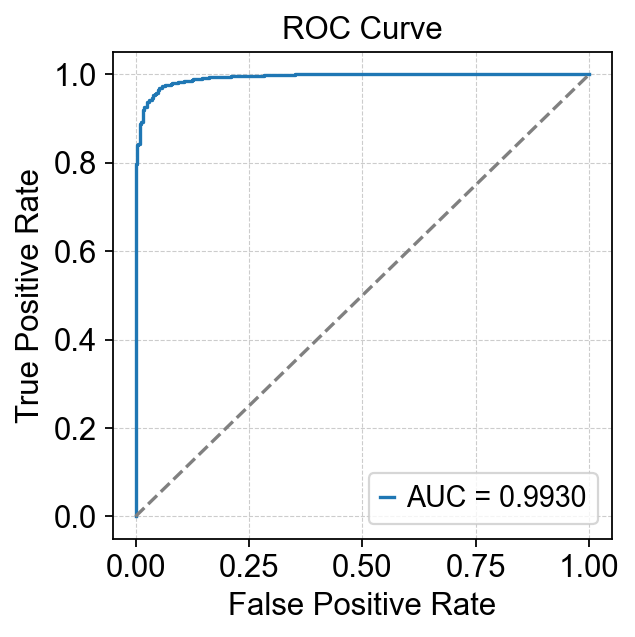

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

Model performance evaluation/Precision_Recall

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

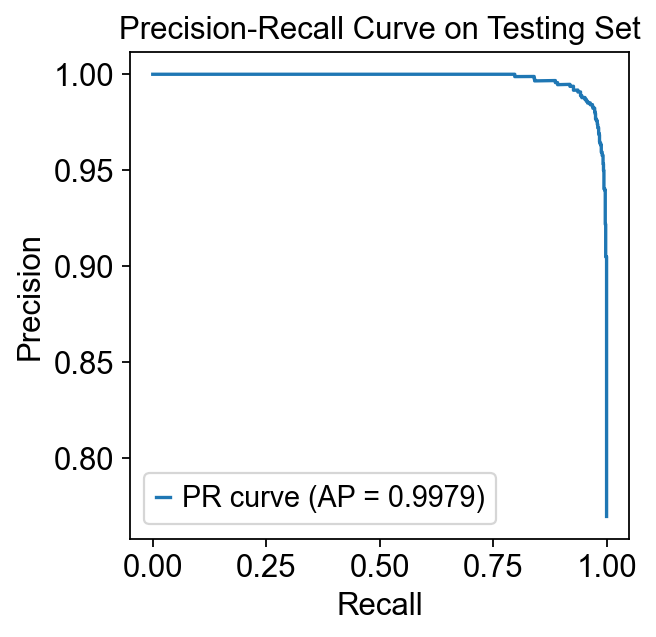

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.plot(recall, precision, label=f"PR curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Testing Set")
plt.legend()
plt.grid(False)
plt.show()

Feature importance

In [33]:
from xgboost import plot_importance

In [34]:
importance_dict = xgb_model.get_booster().get_score(importance_type="weight")

importance_df = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
})
importance_df = importance_df.sort_values(by="importance", ascending=False)

In [35]:
import seaborn as sns

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_62846/3444438936.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), y="feature", x="importance", palette="magma")


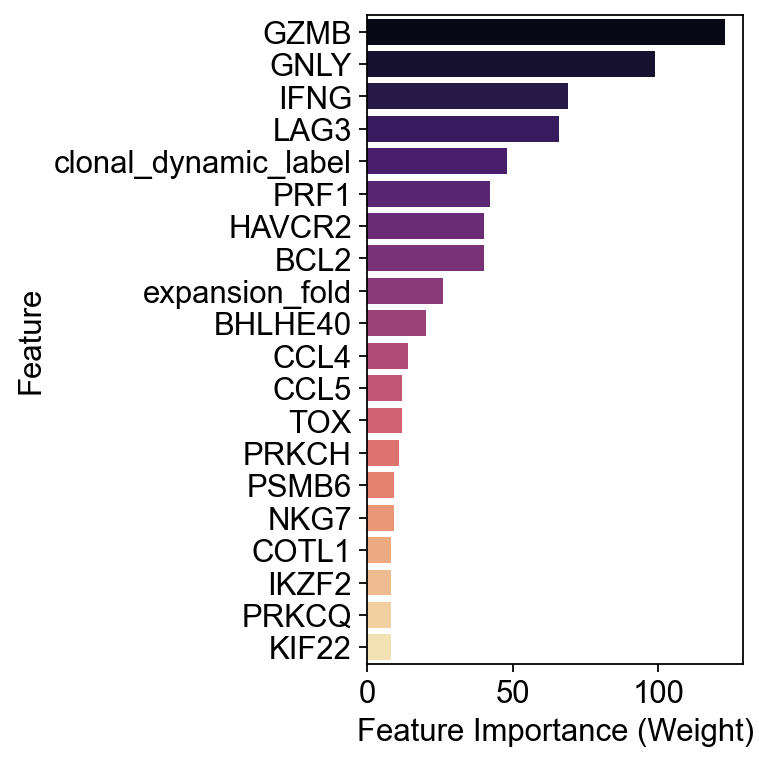

In [36]:
plt.figure(figsize=(5, 5))
sns.barplot(data=importance_df.head(20), y="feature", x="importance", palette="magma")

plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Feature")
plt.grid(False)
plt.tight_layout()
plt.show()

In [71]:
importance_df.head(30)

feature  importance
4                    GZMB       123.0
0                    GNLY        99.0
6                    IFNG        69.0
5                    LAG3        66.0
857  clonal_dynamic_label        48.0
1                    PRF1        42.0
14                 HAVCR2        40.0
33                   BCL2        40.0
858        expansion_fold        26.0
16                BHLHE40        20.0
7                    CCL4        14.0
2                    CCL5        12.0
147                   TOX        12.0
51                  PRKCH        11.0
658                 PSMB6         9.0
3                    NKG7         9.0
855                 COTL1         8.0
21                  IKZF2         8.0
52                  PRKCQ         8.0
484                 KIF22         8.0
149                MAP3K8         8.0
623                ACOT13         8.0
8                    CTSW         8.0
505                 PINX1         8.0
812                  PFN1         7.0
273                  NEMF         7.0
22                   CCL3         7.0
26                TRG-AS1         7.0
831                   TXN         7.0
837                 SNRPG         7.0

In [95]:
from xgboost import plot_tree

/opt/miniconda3/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


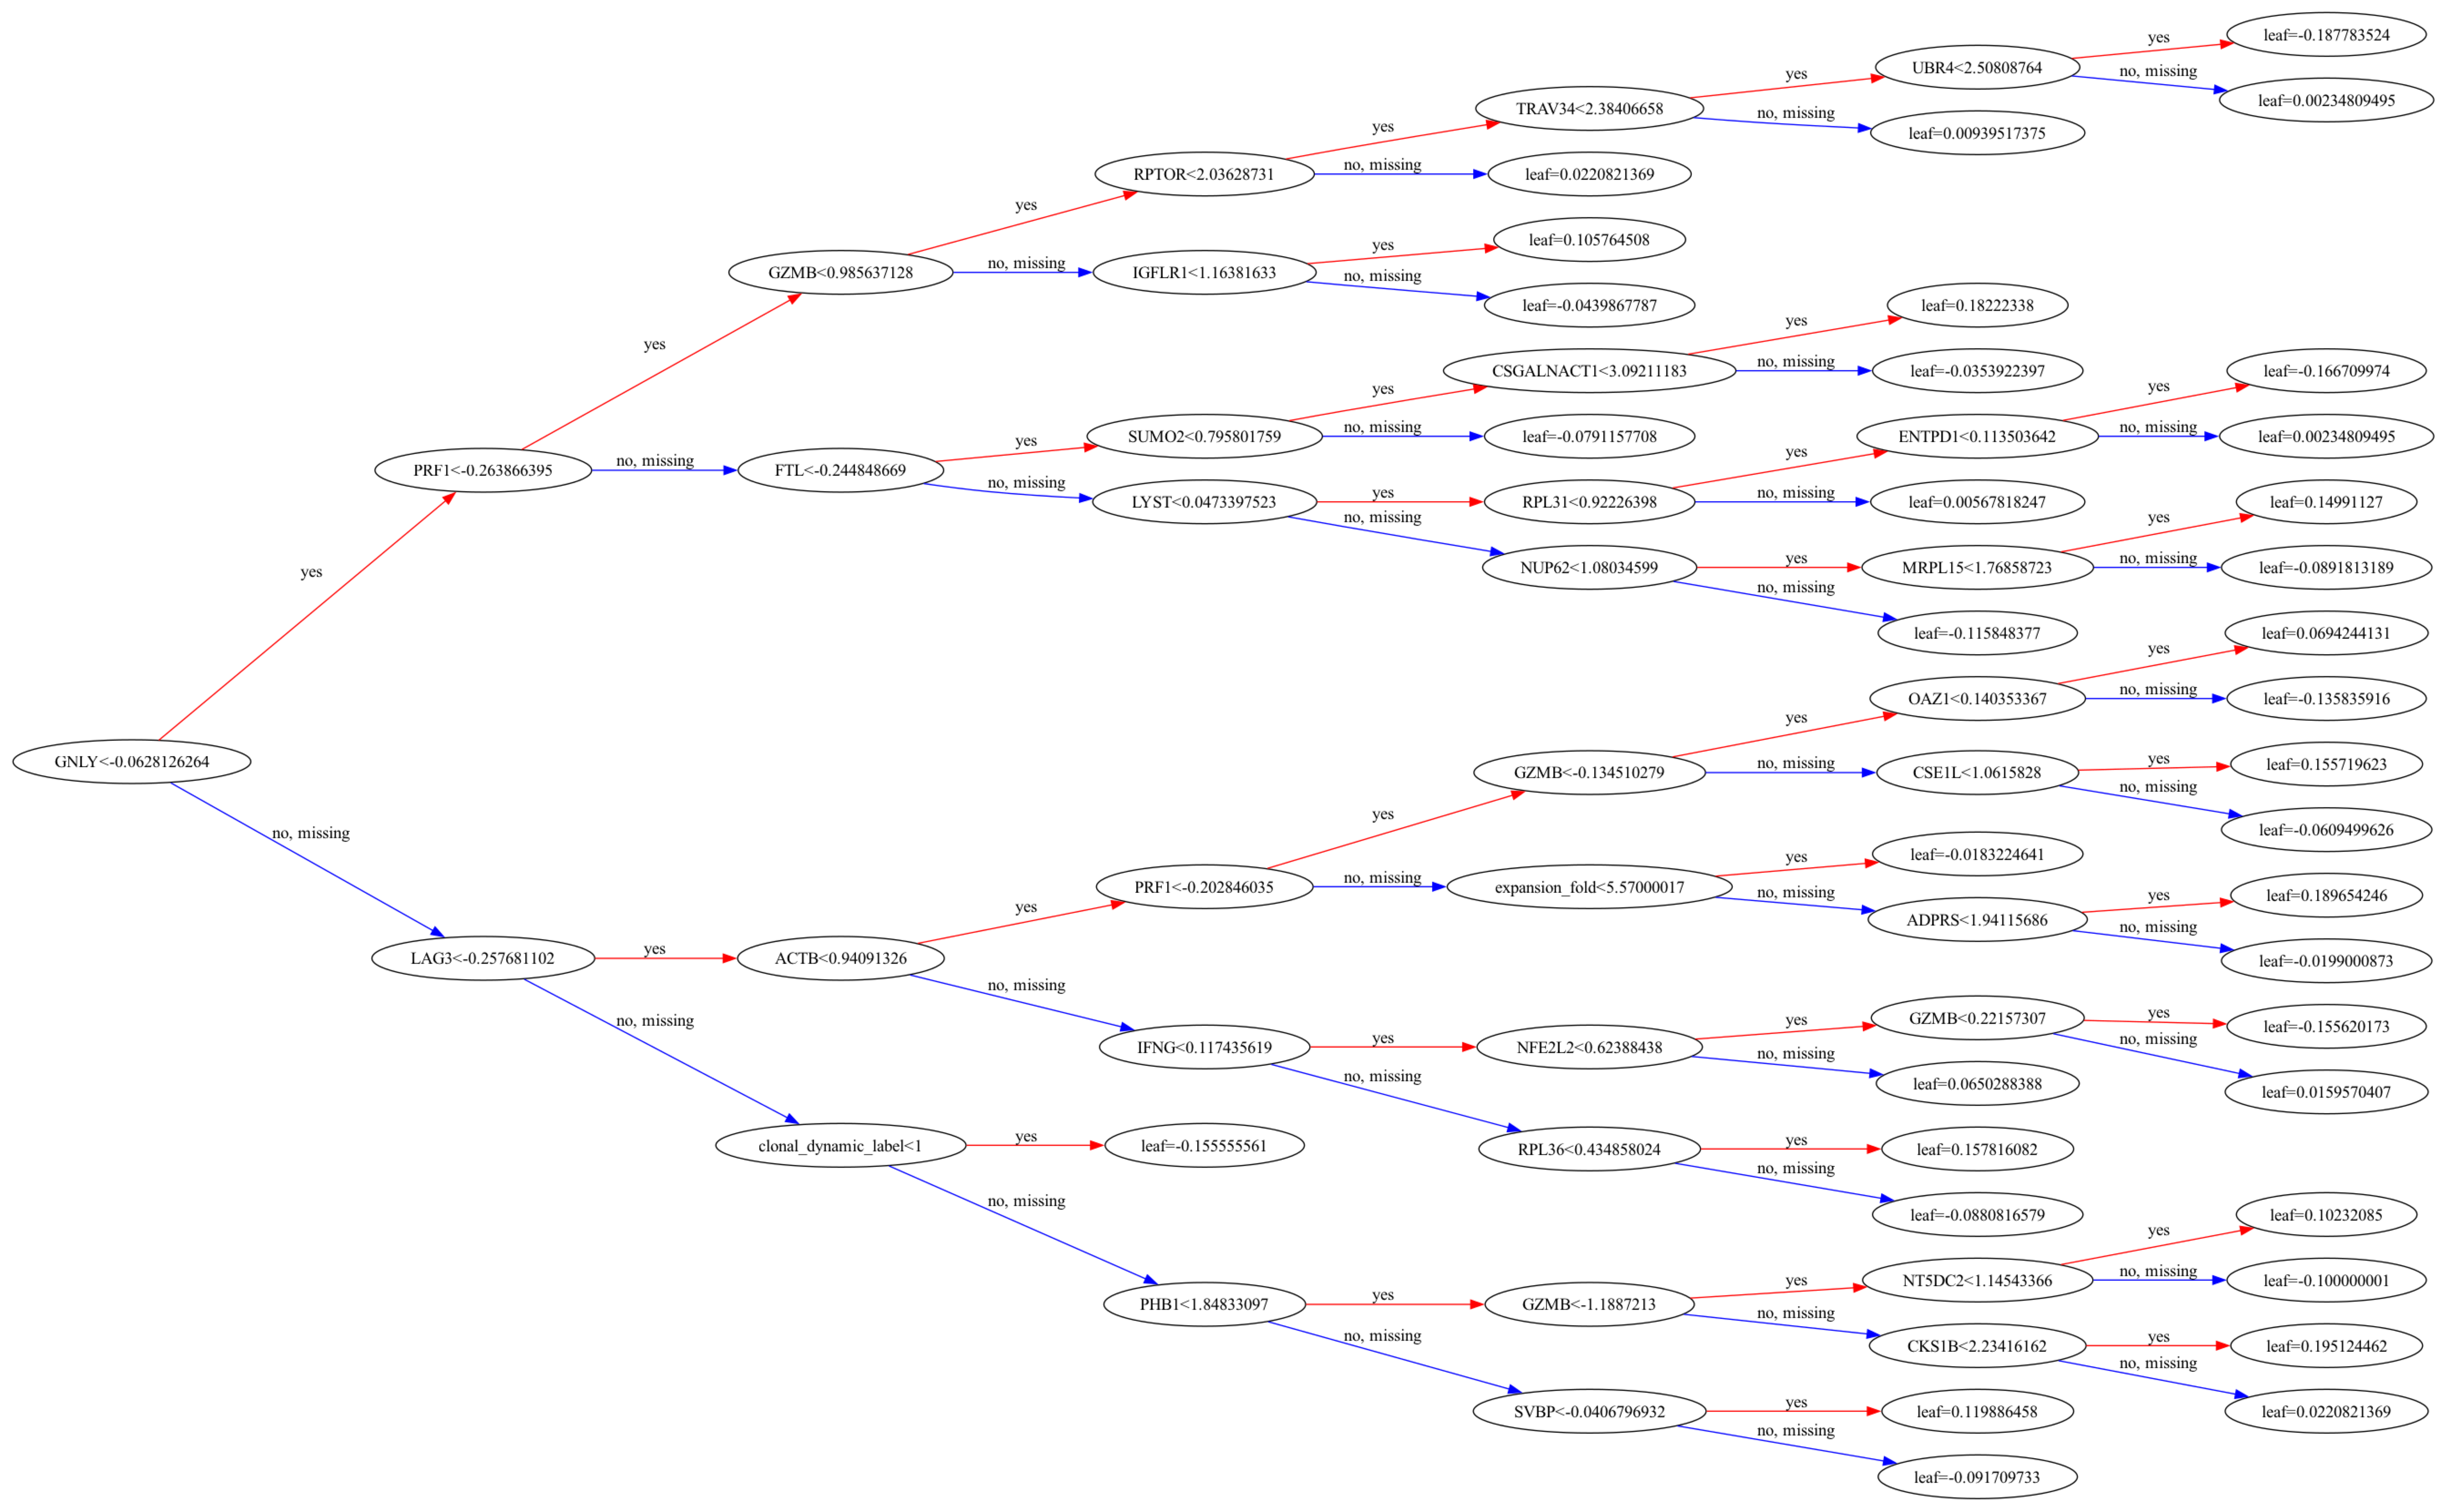

In [98]:
fig, ax = plt.subplots(figsize=(30, 20))
plot_tree(xgb_model, num_trees=0, rankdir="LR", ax=ax)
plt.tight_layout()
plt.show()

Classfication model prediction on total mdata

In [37]:
gex = mdata_filtered["gex"].to_df()[feature_genes]
tcr = mdata_filtered["gex"].obs[["alpha_cdr3_len", "beta_cdr3_len", "clonal_dynamic_label", "expansion_fold"]]
features = pd.concat([gex, tcr], axis=1)

In [39]:
y_total_proba = xgb_model.predict_proba(features)[:, 1]

In [40]:
mdata_filtered["gex"].obs["predicted_reactivity_proba"] = y_total_proba

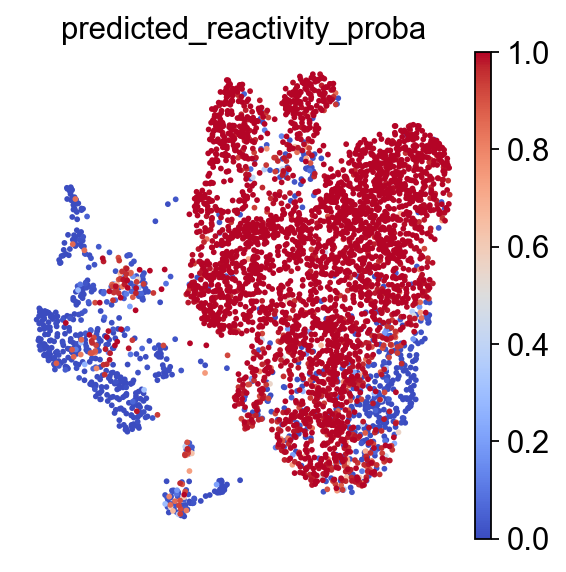

In [41]:
sc.pl.umap(mdata_filtered["gex"], color="predicted_reactivity_proba", cmap="coolwarm", frameon=False, vmax=1, vmin=0)

In [44]:
xgb_predict_df = pd.DataFrame({
    "clone_id": mdata_filtered["gex"].obs["clone_id"],
    "reactivity_proba": y_total_proba
})
clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_62846/3290524566.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()


In [48]:
clone_reactivity = clone_reactivity.reset_index()
clone_reactivity.columns = ["clone_id", "avg_reactivity_probability"]

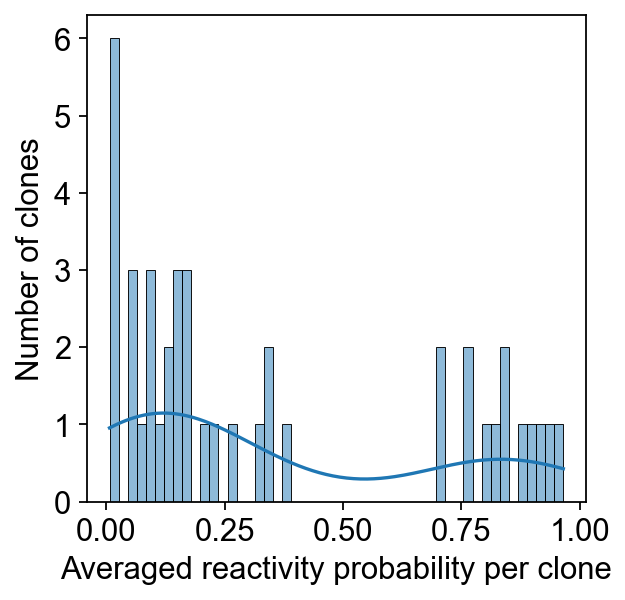

In [50]:
sns.histplot(clone_reactivity["avg_reactivity_probability"], bins=50, kde=True)
plt.xlabel("Averaged reactivity probability per clone")
plt.ylabel("Number of clones")
plt.grid(False)
plt.show()

In [51]:
from sklearn.mixture import GaussianMixture

In [52]:
probs = clone_reactivity["avg_reactivity_probability"].values.reshape(-1, 1)
gmm =GaussianMixture(n_components=2, random_state=42).fit(probs)

labels = gmm.predict(probs)
means = gmm.means_.flatten()
reactive_label = np.argmax(means)

reactivity_threshold = probs[labels == reactive_label].min()
print(f"GMM-derived threshold: {reactivity_threshold:.4f}")

GMM-derived threshold: 0.6973


In [53]:
clone_reactivity["clone_reactivity"] = clone_reactivity["avg_reactivity_probability"].apply(
    lambda x: "Reactive" if x > reactivity_threshold else "Nonreactive"
)

In [66]:
clone_reactivity = clone_reactivity.set_index("clone_id")

In [67]:
mdata_filtered["gex"].obs["prediction"] = mdata_filtered["gex"].obs["clone_id"].map(
    clone_reactivity["clone_reactivity"]
)

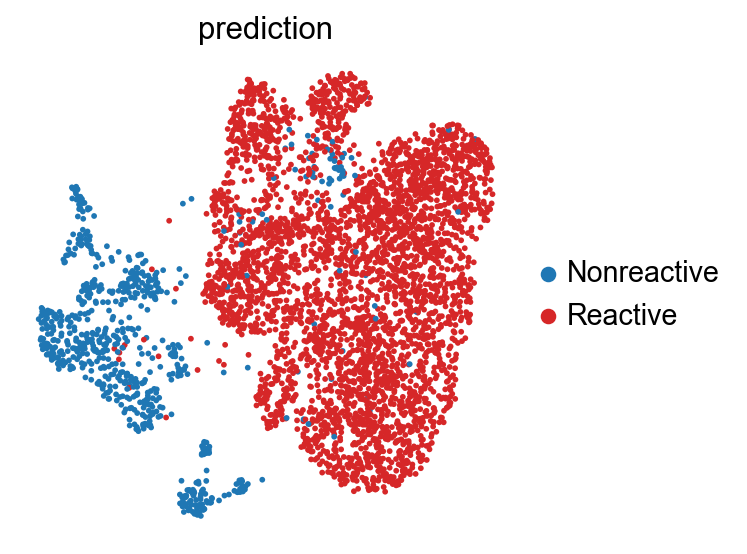

In [69]:
sc.pl.umap(mdata_filtered["gex"], color="prediction", palette=["tab:blue", "tab:red"], frameon=False)

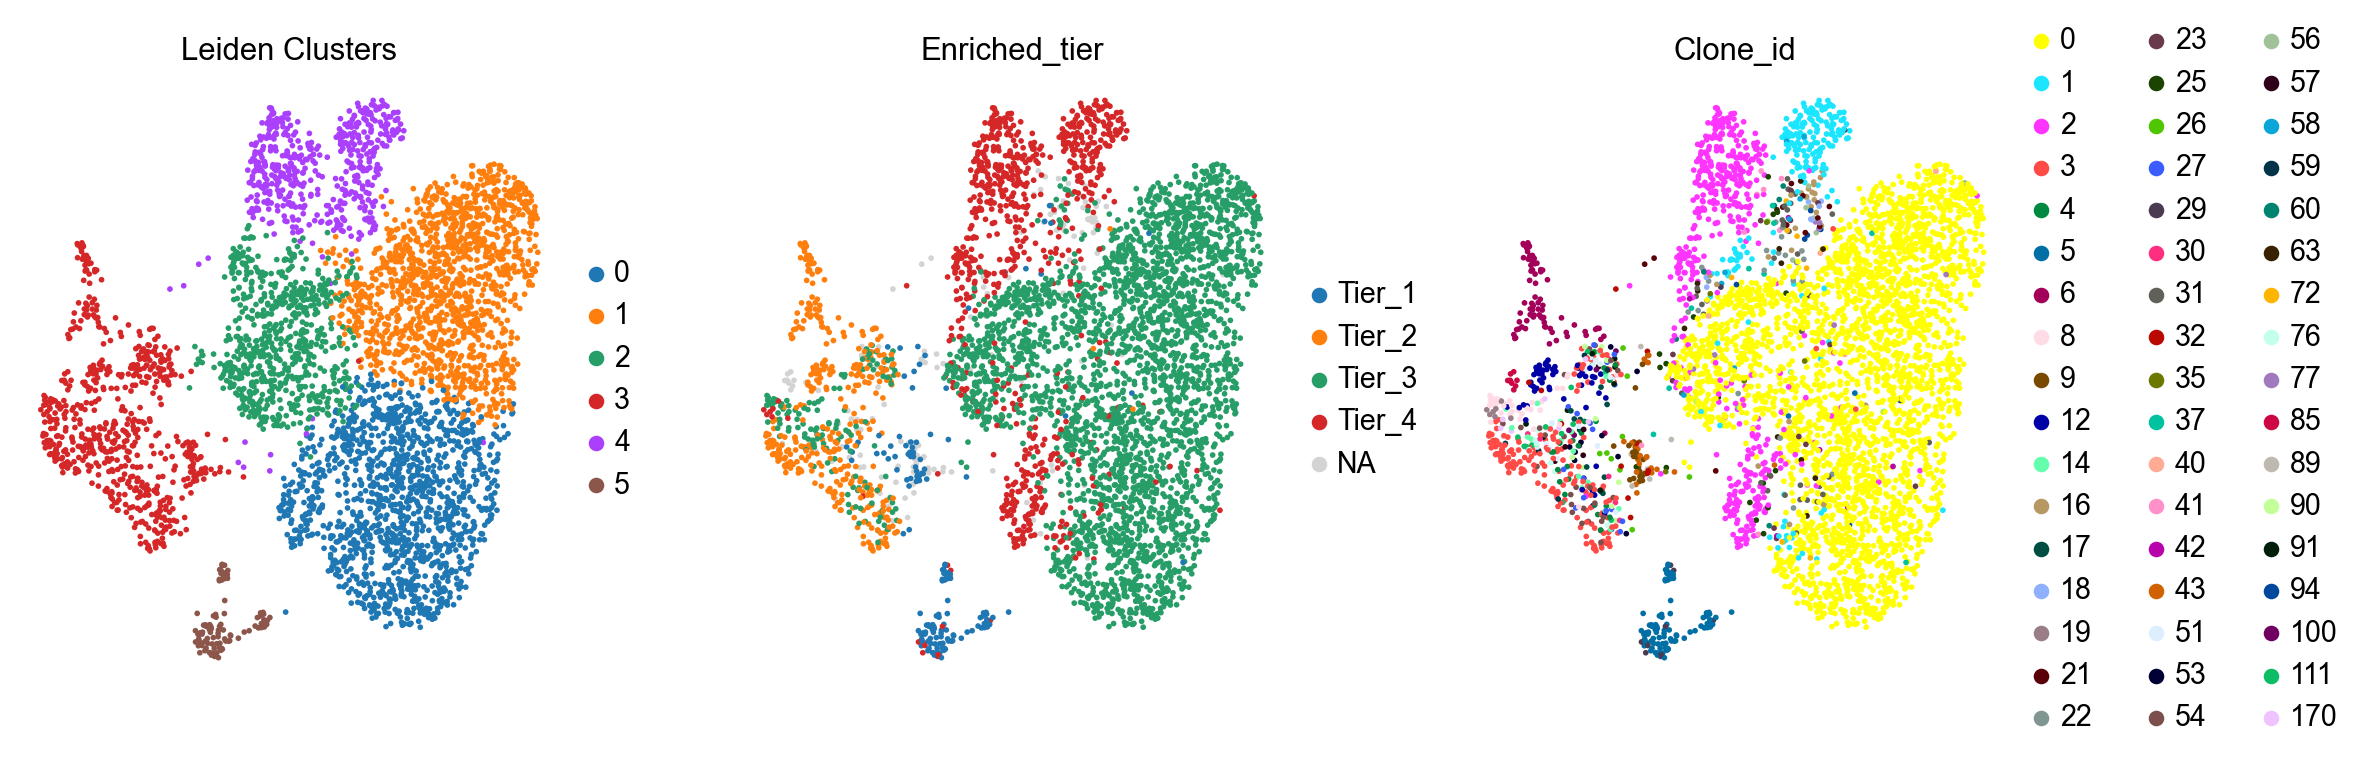

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot into each axis
sc.pl.umap(mdata["gex"], color="leiden", ax=axes[0], show=False, frameon=False, title="Leiden Clusters")
sc.pl.umap(mdata["gex"], color="enriched_tier", ax=axes[1], show=False, frameon=False, title="Enriched_tier")
sc.pl.umap(mdata["gex"], color="clone_id", ax=axes[2], show=False, frameon=False, title="Clone_id")

# Adjust spacing
plt.tight_layout()
plt.show()

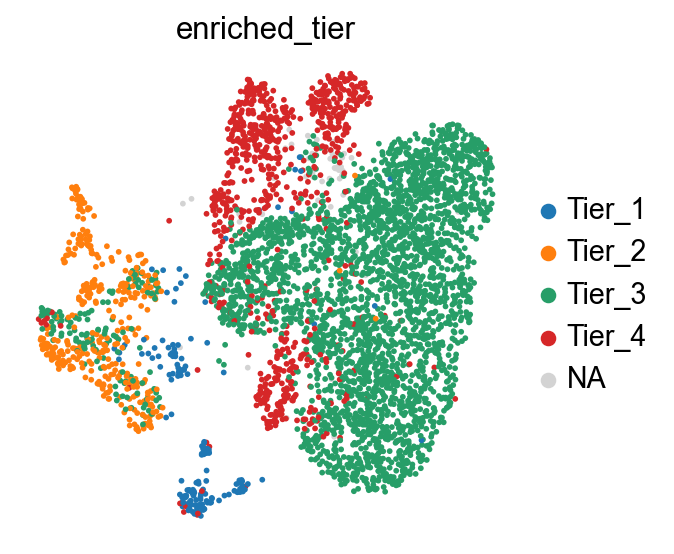

In [94]:
sc.pl.umap(mdata_filtered["gex"], color="enriched_tier", frameon=False)

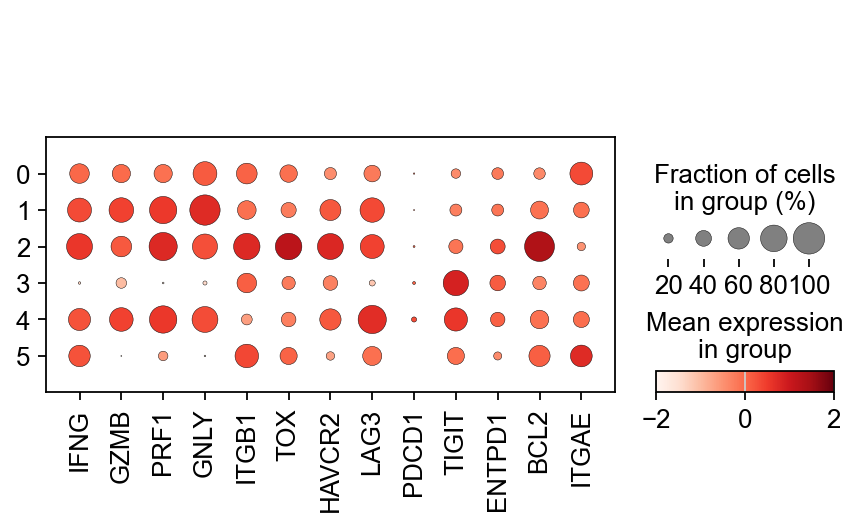

In [83]:
sc.pl.dotplot(mdata_filtered["gex"], 
              ["IFNG", "GZMB", "PRF1", "GNLY", "ITGB1", "TOX", "HAVCR2", "LAG3", "PDCD1", "TIGIT", "ENTPD1", "BCL2", "ITGAE",], 
              groupby="leiden", 
              use_raw=False,
              vmax=2,
              vmin=-2
              )

Classfication Model(Train with gene expression only)

In [100]:
xgb_gex_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42
)

In [101]:
xgb_gex_model.fit(gex_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [103]:
y_gex_pred = xgb_gex_model.predict(gex_test)
y_gex_proba = xgb_gex_model.predict_proba(gex_test)[:, 1]

In [104]:
print("ROC_AUC:", roc_auc_score(y_test, y_gex_proba))

ROC_AUC: 0.9822123401889938


5-fold Cross Validation

In [105]:
scores = cross_val_score(xgb_gex_model, gex_train, y_train, cv=5, scoring="roc_auc")
print("Cross-validated AUCs:", scores)
print("Mean AUC:", np.mean(scores))

Cross-validated AUCs: [0.97465278 0.98421586 0.97456294 0.98018648 0.97452737]
Mean AUC: 0.9776290846696314


ROC_AUC

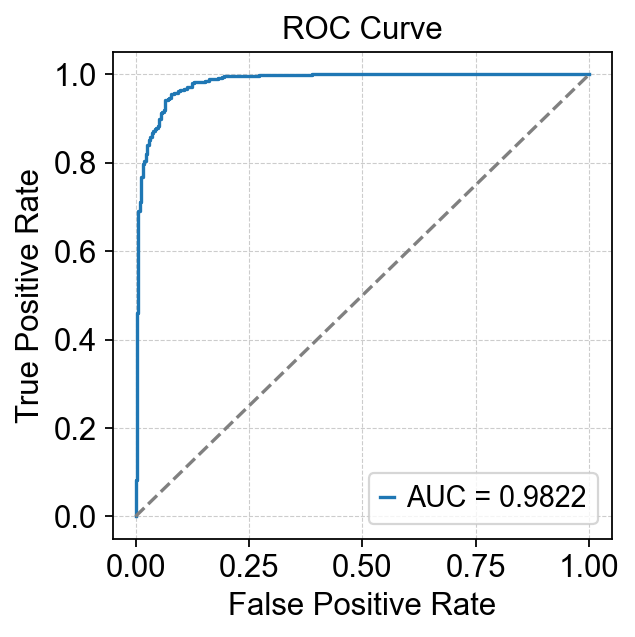

In [106]:
fpr, tpr, thresholds = roc_curve(y_test, y_gex_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_gex_proba):.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

Precision/Recall

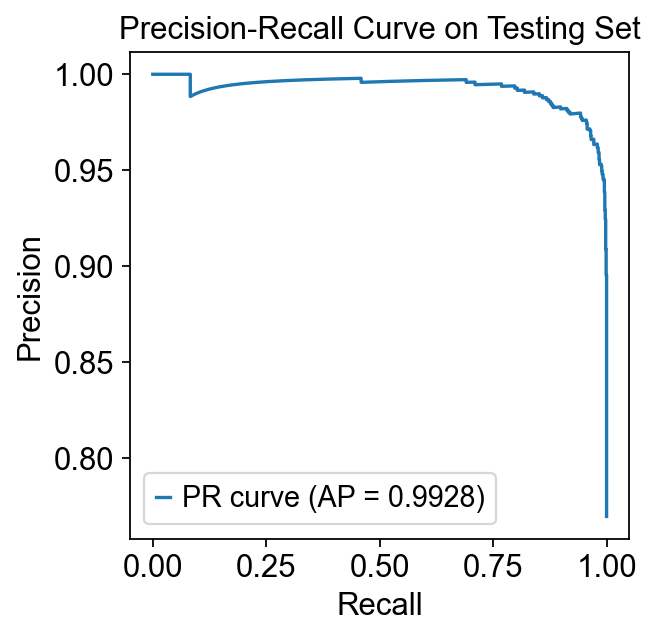

In [109]:
precision, recall, thresholds = precision_recall_curve(y_test, y_gex_proba)
ap = average_precision_score(y_test, y_gex_proba)

plt.plot(recall, precision, label=f"PR curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Testing Set")
plt.legend()
plt.grid(False)
plt.show()

In [110]:
importance_dict = xgb_gex_model.get_booster().get_score(importance_type="weight")

importance_df_gex = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
})
importance_df_gex = importance_df_gex.sort_values(by="importance", ascending=False)

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_62846/3953817300.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df_gex.head(20), y="feature", x="importance", palette="magma")


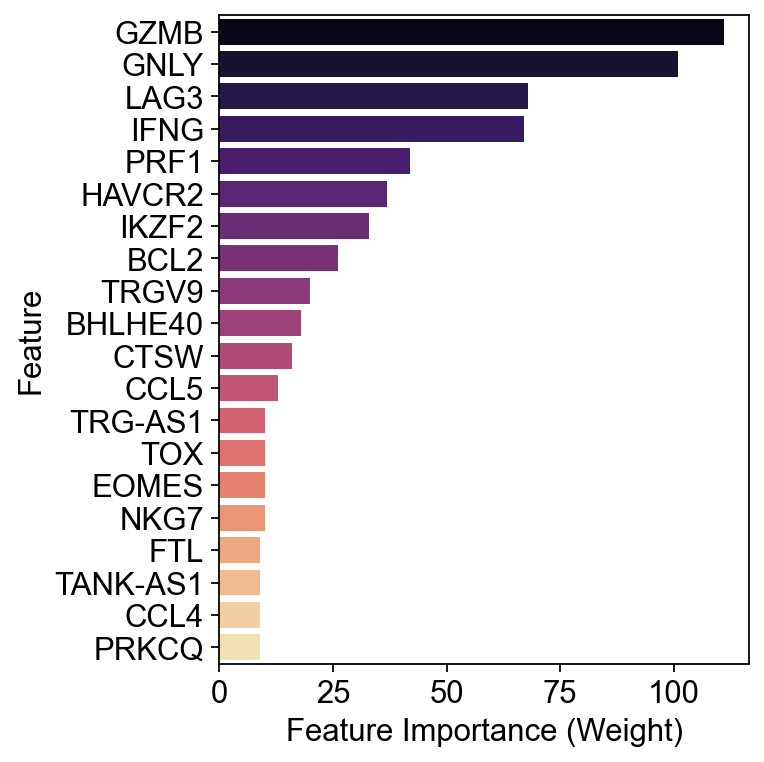

In [111]:
plt.figure(figsize=(5, 5))
sns.barplot(data=importance_df_gex.head(20), y="feature", x="importance", palette="magma")

plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Feature")
plt.grid(False)
plt.tight_layout()
plt.show()

Classification on total mdata

In [112]:
y_gex_total_proba = xgb_gex_model.predict_proba(gex)[:, 1]

In [113]:
mdata_filtered["gex"].obs["gex_predicted_reactivity_proba"] = y_gex_total_proba

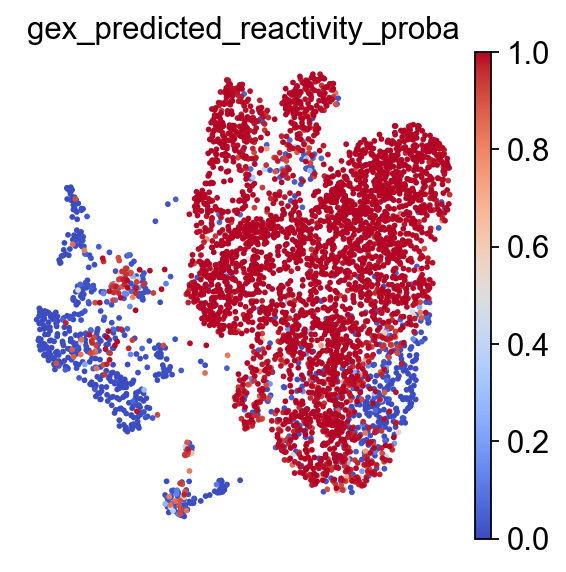

In [114]:
sc.pl.umap(mdata_filtered["gex"], color="gex_predicted_reactivity_proba", cmap="coolwarm", frameon=False, vmax=1, vmin=0)

In [115]:
xgb_gex_predict_df = pd.DataFrame({
    "clone_id": mdata_filtered["gex"].obs["clone_id"],
    "reactivity_proba": y_gex_total_proba
})
clone_reactivity_gex = xgb_gex_predict_df.groupby("clone_id")["reactivity_proba"].mean()

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_62846/1722343418.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clone_reactivity_gex = xgb_gex_predict_df.groupby("clone_id")["reactivity_proba"].mean()


In [116]:
clone_reactivity_gex = clone_reactivity_gex.reset_index()
clone_reactivity_gex.columns = ["clone_id", "avg_reactivity_probability"]

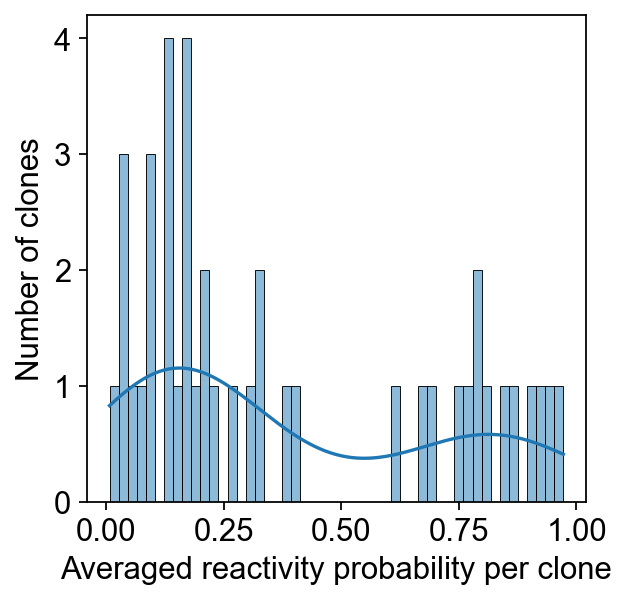

In [117]:
sns.histplot(clone_reactivity_gex["avg_reactivity_probability"], bins=50, kde=True)
plt.xlabel("Averaged reactivity probability per clone")
plt.ylabel("Number of clones")
plt.grid(False)
plt.show()

In [118]:
probs = clone_reactivity_gex["avg_reactivity_probability"].values.reshape(-1, 1)
gmm =GaussianMixture(n_components=2, random_state=42).fit(probs)

labels = gmm.predict(probs)
means = gmm.means_.flatten()
reactive_label = np.argmax(means)

gex_reactivity_threshold = probs[labels == reactive_label].min()
print(f"GMM-derived threshold: {gex_reactivity_threshold:.4f}")

GMM-derived threshold: 0.6087


In [119]:
clone_reactivity_gex["clone_reactivity"] = clone_reactivity_gex["avg_reactivity_probability"].apply(
    lambda x: "Reactive" if x > gex_reactivity_threshold else "Nonreactive"
)

In [120]:
clone_reactivity_gex = clone_reactivity_gex.set_index("clone_id")

In [121]:
mdata_filtered["gex"].obs["gex_prediction"] = mdata_filtered["gex"].obs["clone_id"].map(
    clone_reactivity_gex["clone_reactivity"]
)

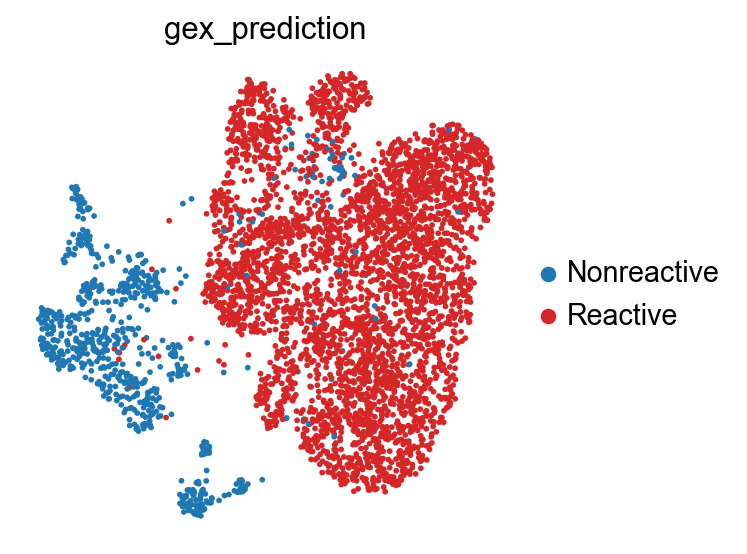

In [122]:
sc.pl.umap(mdata_filtered["gex"], color="gex_prediction", palette=["tab:blue", "tab:red"], frameon=False)

In [123]:
clone_reactivity_gex

avg_reactivity_probability clone_reactivity
clone_id                                             
0                           0.871669         Reactive
1                           0.941441         Reactive
2                           0.921375         Reactive
3                           0.169375      Nonreactive
4                           0.317746      Nonreactive
5                           0.229945      Nonreactive
6                           0.085589      Nonreactive
8                           0.086420      Nonreactive
9                           0.048659      Nonreactive
12                          0.135768      Nonreactive
14                          0.144673      Nonreactive
16                          0.815263         Reactive
18                          0.040382      Nonreactive
19                          0.031079      Nonreactive
21                          0.188164      Nonreactive
22                          0.847362         Reactive
23                          0.797206         Reactive
26                          0.387496      Nonreactive
27                          0.102947      Nonreactive
29                          0.314486      Nonreactive
30                          0.174235      Nonreactive
31                          0.677448         Reactive
37                          0.748111         Reactive
40                          0.608656      Nonreactive
41                          0.397771      Nonreactive
42                          0.174375      Nonreactive
51                          0.173386      Nonreactive
53                          0.765067         Reactive
54                          0.073254      Nonreactive
56                          0.038644      Nonreactive
58                          0.972032         Reactive
60                          0.797136         Reactive
63                          0.899073         Reactive
72                          0.124824      Nonreactive
76                          0.141220      Nonreactive
77                          0.210029      Nonreactive
89                          0.333928      Nonreactive
91                          0.007096      Nonreactive
94                          0.686152         Reactive
100                         0.206582      Nonreactive
111                         0.136851      Nonreactive
170                         0.273601      Nonreactive

In [125]:
xgb_gex_model.save_model("/Users/jerryaaaaaa/taxidermic_gex_model.json")

In [126]:
import pickle

with open("/Users/jerryaaaaaa/taxidermic_gex_features.pkl", "wb") as f:
    pickle.dump(feature_genes, f)